In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from data_utils import *
from model_utils import *
import gpytorch
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Load data

/tmp/ipykernel_3395721/2985328647.py:33: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))


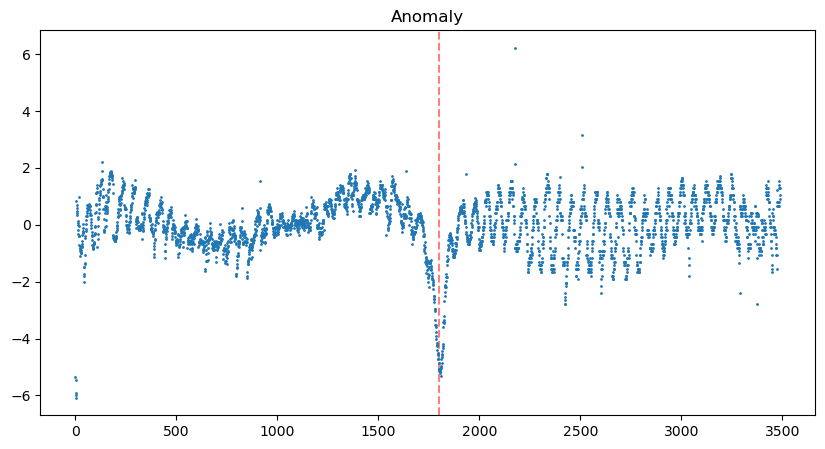

Anomaly locations:
[1797.9708824760335]
39.59375


In [5]:
# Load a file and inject an anomaly
data_dir = '../data/k2/'
filename = 'k2_77.fits'
x, y, y_err = load_k2_data(data_dir + filename)

# Inject anomalies
steps, y, anomaly_locs = inject_anomaly(y, num_anomalies=1, seed=5, shapes=["gaussian"])

# Standardize data to have mean 0 and std of 1
mean_y = np.mean(y)
std_y = np.std(y)
y = (y - mean_y) / std_y
y_err = y_err / std_y

# Create original copies of x and y
x_orig = np.copy(x)
y_orig = np.copy(y)
y_err_orig = np.copy(y_err)

# Convert to tensors
x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
y_err_tensor = torch.tensor(y_err, dtype=torch.float32).to(device)

# Plot
plt.figure(figsize=(10,5))
for i in range(len(anomaly_locs)):
    plt.axvline(x=anomaly_locs[i], color='r', linestyle='--', alpha=0.5)
plt.plot(steps, y, '.', markersize=2)
plt.title("Anomaly")
plt.show()

# Print anomaly_locs, both indices and x[i]
print("Anomaly locations:")
print(anomaly_locs)
for i in anomaly_locs: print(x[int(i)])

# Anomaly detection with GP
### Method:
1. Perform GP regression on the timeseries.
2. Find the most significant outlier point.
3. Exclude that point and redo regression. See if GP improves by some threshold.
4. Exclude adjacent points and redo step 3.
5. Repeat step 4 as long as GP improves the fit by some threshold.
6. If no improvement, define anomaly signal as the difference between data and regression in that interval of points.
7. Repeat steps 2-6 for a defined number of anomalies.

/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(
/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(




 New dip identified at anomalous index 4, x[index] = 0.09375


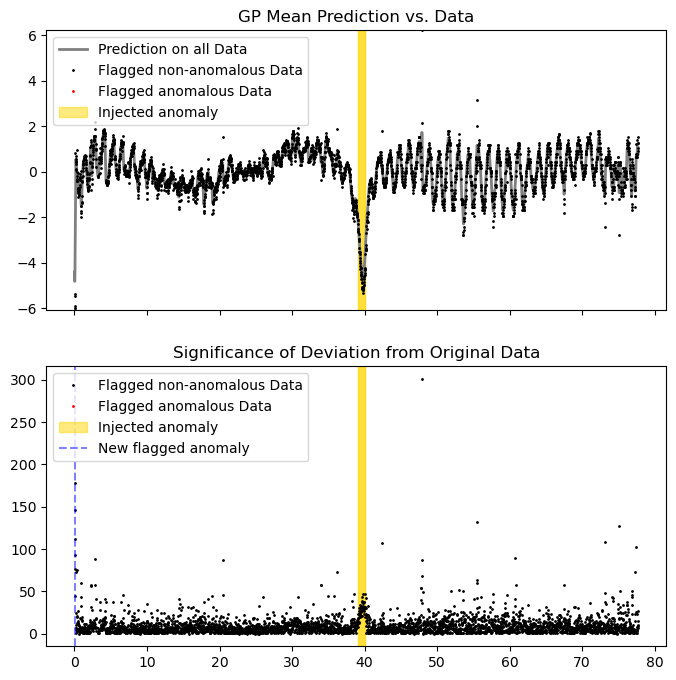

Old metric: 1000000.0 - New metric: 1.0360032320022583 = Diff metric: 999998.9375
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 2:6
Old metric: 1.0360032320022583 - New metric: 1.0353680849075317 = Diff metric: 0.0006351470947265625
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 0:8
Old metric: 1.0353680849075317 - New metric: 1.0346481800079346 = Diff metric: 0.000719904899597168
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 0:10
Old metric: 1.0346481800079346 - New metric: 1.034567952156067 = Diff metric: 8.022785186767578e-05
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 0:12
Old metric: 1.034567952156067 - New metric: 1.0344820022583008 = Diff metric: 8.594989776611328e-05
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 0:14
Old metric: 1.0344820022583008 - New metric: 1.0345345735549927 = Diff metric: -5.257129669189453e-05
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 0:16


 

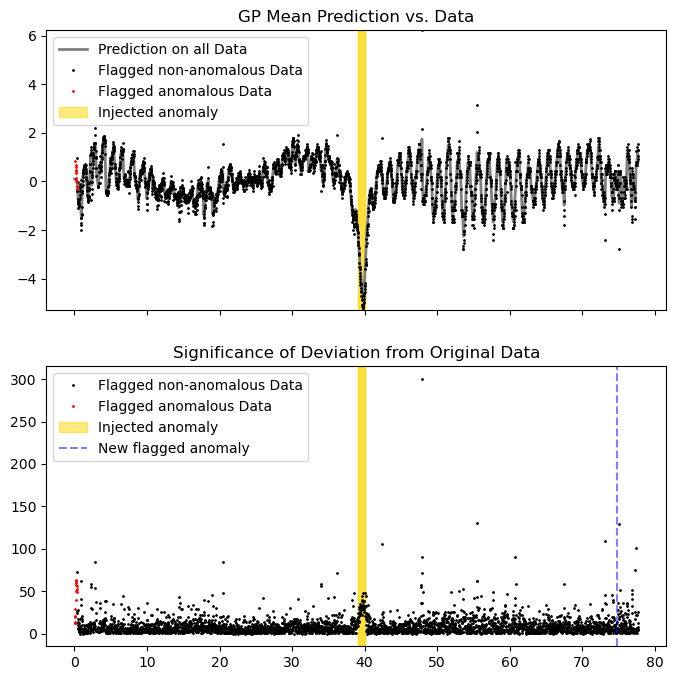

Old metric: 1000000.0 - New metric: 1.0344935655593872 = Diff metric: 999998.9375
Anomaly index 1 x[i] 0.03125, left_edge:right_edge 3356:3360
Old metric: 1.0344935655593872 - New metric: 1.0345191955566406 = Diff metric: -2.562999725341797e-05
Anomaly index 1 x[i] 0.03125, left_edge:right_edge 3354:3362


 New dip identified at anomalous index 3350, x[index] = 74.59375


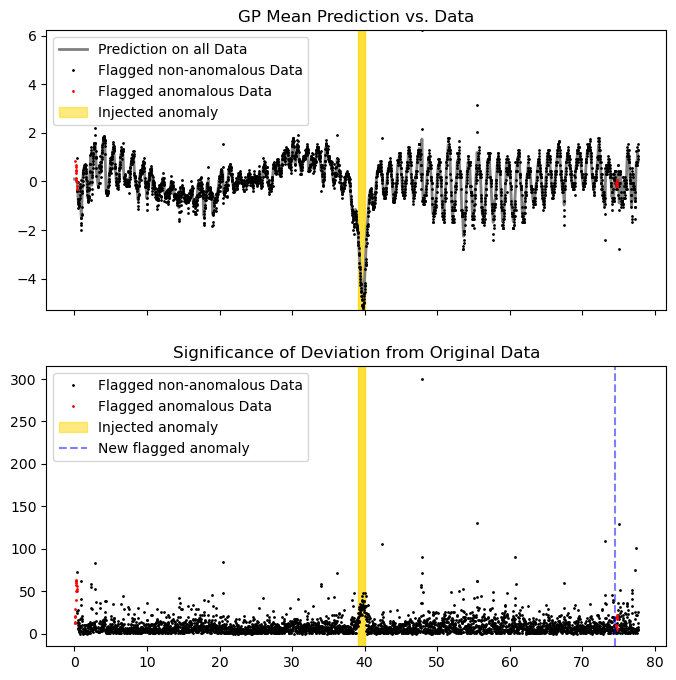

Old metric: 1000000.0 - New metric: 1.0345197916030884 = Diff metric: 999998.9375
Anomaly index 2 x[i] 0.05208333333333333, left_edge:right_edge 3348:3352
Old metric: 1.0345197916030884 - New metric: 1.0345139503479004 = Diff metric: 5.841255187988281e-06
Anomaly index 2 x[i] 0.05208333333333333, left_edge:right_edge 3346:3354
Old metric: 1.0345139503479004 - New metric: 1.034459114074707 = Diff metric: 5.4836273193359375e-05
Anomaly index 2 x[i] 0.05208333333333333, left_edge:right_edge 3344:3356
Old metric: 1.034459114074707 - New metric: 1.0343912839889526 = Diff metric: 6.783008575439453e-05
Anomaly index 2 x[i] 0.05208333333333333, left_edge:right_edge 3342:3358
Old metric: 1.0343912839889526 - New metric: 1.0344237089157104 = Diff metric: -3.24249267578125e-05
Anomaly index 2 x[i] 0.05208333333333333, left_edge:right_edge 3340:3360


 New dip identified at anomalous index 3336, x[index] = 74.28125


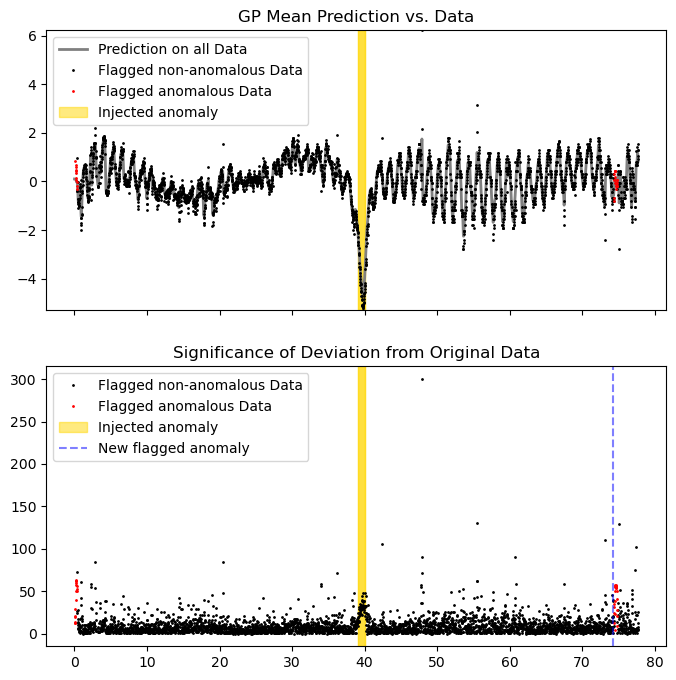

Old metric: 1000000.0 - New metric: 1.03432297706604 = Diff metric: 999998.9375
Anomaly index 3 x[i] 0.07291666666666667, left_edge:right_edge 3334:3338
Old metric: 1.03432297706604 - New metric: 1.0343804359436035 = Diff metric: -5.745887756347656e-05
Anomaly index 3 x[i] 0.07291666666666667, left_edge:right_edge 3332:3340


In [6]:
# Hyperparameters
which_metric = 'msll' # 'rmse', 'nlpd', msll, or default is 'mll'
num_anomalies = 4
num_steps = len(x)
anomalous = np.zeros(num_steps) # 0 means non-anomalous, 1 means anomalous at that time step
initial_lengthscale = 0.3**2 # If None, no lengtshcale is used (default) and the theta parameter is the identity matrix
expansion_param = 2 # how many indices left and right to increase anomaly by

# Train GP model
model, likelihood, mll = train_gp(x_tensor, y_tensor, y_err_tensor, training_iterations=30, lengthscale=initial_lengthscale, device=device)
final_lengthscale = model.covar_module.base_kernel.rbf_kernel.lengthscale.item()

# Step 7 (repeat for every anomaly)
for i in range(num_anomalies):
    # Get subset of data that is flagged an non-anomalous
    x_sub = torch.tensor(x[anomalous == 0], dtype=torch.float32).to(device)
    y_sub = torch.tensor(y[anomalous == 0], dtype=torch.float32).to(device)
    y_err_sub = torch.tensor(y_err[anomalous == 0], dtype=torch.float32).to(device)

    # Re-fit the GP on non-anomalous data
    model, likelihood, mll = train_gp(x_sub, y_sub, y_err_sub, training_iterations=1, lengthscale=final_lengthscale, device=device)

    # Predict
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(x_tensor))
        pred_mean = observed_pred.mean.cpu().numpy()
        pred_var = observed_pred.variance.cpu().numpy()

    # Find index of largest deviation
    sig_dev = (pred_mean - y) / y_err
    index = np.argmax(sig_dev[anomalous == 0])
    print(f"\n\n New dip identified at anomalous index {index}, x[index] = {x[index]}")

    # Plot
    fig, axs = plt.subplots(2, 1, sharex = True, figsize = (8, 8))
    axs[0].set_title("GP Mean Prediction vs. Data")
    axs[0].plot(x, pred_mean, "grey", lw=2, label="Prediction on all Data")
    axs[0].plot(x[(anomalous==0)], y_orig[(anomalous==0)], '.k', markersize=2, label="Flagged non-anomalous Data")
    axs[0].plot(x[(anomalous==1)], y_orig[(anomalous==1)], '.r', markersize=2, label="Flagged anomalous Data")
    # Plot the anomaly region
    axs[0].axvspan(x[int(anomaly_locs[0])] - 0.5, x[int(anomaly_locs[0])] + 0.5, color='gold', alpha=0.5, label="Injected anomaly")
    for j in anomaly_locs:
        axs[0].axvspan(x[int(j)] - 0.5, x[int(j)] + 0.5, color='gold', alpha=0.5)
    axs[0].set_ylim(np.min(y_sub.cpu().numpy()), np.max(y_sub.cpu().numpy()))
    axs[0].legend()

    sig_dev = (pred_mean - y) / y_err
    axs[1].set_title("Significance of Deviation from Original Data")
    axs[1].plot(x[(anomalous==0)], np.abs(sig_dev[(anomalous==0)]), '.k', markersize=2, label="Flagged non-anomalous Data")
    axs[1].plot(x[(anomalous==1)], np.abs(sig_dev[(anomalous==1)]), '.r', markersize=2, label="Flagged anomalous Data")
    # Plot the anomaly region
    axs[1].axvspan(x[int(anomaly_locs[0])] - 0.5, x[int(anomaly_locs[0])] + 0.5, color='gold', alpha=0.5, label="Injected anomaly")
    for j in anomaly_locs:
        axs[1].axvspan(x[int(j)] - 0.5, x[int(j)] + 0.5, color='gold', alpha=0.5)
    # Plot the index of the new anomaly
    axs[1].axvline(x=x[index], color='b', linestyle='--', alpha=0.5, label="New flagged anomaly")
    axs[1].legend()
    plt.show(block=False)
    plt.pause(1)
    plt.close()

    # Intialize variables for expanding anomalous region
    left_edge = index
    right_edge = index
    diff_metric = 1e6
    metric = 1e6
    
    # While the metric is decreasing, expand the anomalous edges
    while diff_metric > 0:
        # Subset x, y, and y_err
        subset = (((np.arange(len(x)) > right_edge) | (np.arange(len(x)) < left_edge)) & (anomalous == 0))
        x_sub = torch.tensor(x[subset], dtype=torch.float32).to(device)
        y_sub = torch.tensor(y[subset], dtype=torch.float32).to(device)
        y_err_sub = torch.tensor(y_err[subset], dtype=torch.float32).to(device)
        
        # Re-fit the GP on non-anomalous data
        model, likelihood, mll = train_gp(x_sub, y_sub, y_err_sub, training_iterations=1, lengthscale=final_lengthscale, device=device)

        # Predict on subset
        model.eval()
        likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(x_sub))
            pred_mean = observed_pred.mean.cpu().numpy()
            pred_var = observed_pred.variance.cpu().numpy()

        # Calculate metric difference
        old_metric = metric

        if which_metric == 'nlpd':
            metric = gpytorch.metrics.negative_log_predictive_density(observed_pred, y_sub)
        elif which_metric == 'msll':
            metric = gpytorch.metrics.mean_standardized_log_loss(observed_pred, y_sub)
        elif which_metric == 'rmse':
            metric = np.sqrt(np.mean((pred_mean - y_sub.cpu().numpy())**2))
        else: # metric == mll
            model.eval()
            likelihood.eval()
            with torch.no_grad(), gpytorch.settings.fast_pred_var():
                output = model(x_sub)
                metric = mll(output, y_sub)

        diff_metric = old_metric - metric # smaller is better
        print(f"Old metric: {old_metric} - New metric: {metric} = Diff metric: {diff_metric}")

        # Expand anomalous region on both sides
        if left_edge >= 0 + expansion_param:
            left_edge -= expansion_param
        if right_edge < len(x) - expansion_param:
            right_edge += expansion_param

        print(f"Anomaly index {i} x[i] {x[i]}, left_edge:right_edge {left_edge}:{right_edge}")

    # Update anomalous array
    y[left_edge:right_edge] = pred_mean[left_edge:right_edge]
    anomalous[left_edge:right_edge] = 1

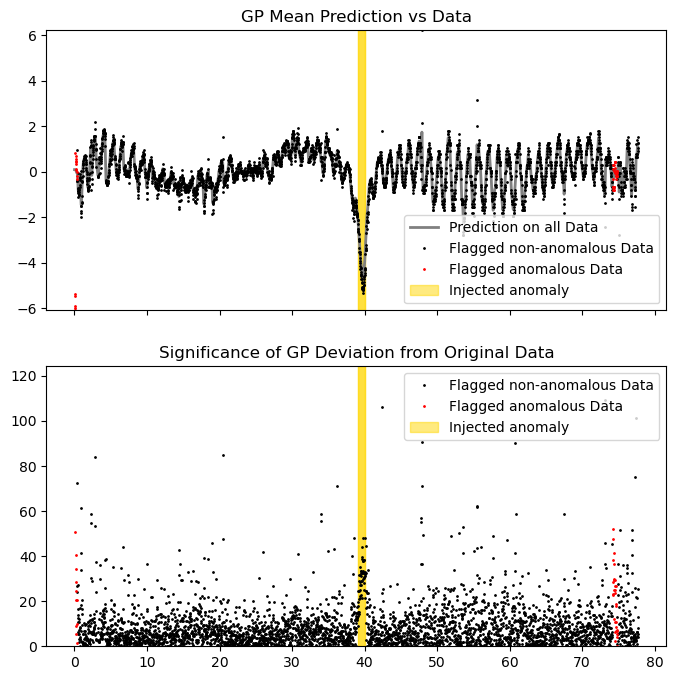

In [7]:
# Fit on final subset
model, likelihood, mll = train_gp(x_sub, y_sub, y_err_sub, training_iterations=1, lengthscale=final_lengthscale, device=device)

# Predict
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x_tensor))
    pred_mean = observed_pred.mean.cpu().numpy()
    pred_var = observed_pred.variance.cpu().numpy()

# Plot
fig, axs = plt.subplots(2, 1, sharex = True, figsize=(8, 8))
axs[0].set_title("GP Mean Prediction vs Data")
axs[0].plot(x, pred_mean, "grey", lw=2, label="Prediction on all Data")
axs[0].plot(x_sub.cpu().numpy(), y_sub.cpu().numpy(), '.k', markersize=2, label="Flagged non-anomalous Data")
axs[0].set_ylim(np.min(y_orig), np.max(y_orig))
axs[0].plot(x_orig[(anomalous==1)], y_orig[(anomalous==1)], '.r', markersize=2, label="Flagged anomalous Data")
# Plot the anomaly region
axs[0].axvspan(x[int(anomaly_locs[0])] - 0.5, x[int(anomaly_locs[0])] + 0.5, color='gold', alpha=0.5, label="Injected anomaly")
for j in anomaly_locs:
    axs[0].axvspan(x[int(j)] - 0.5, x[int(j)] + 0.5, color='gold', alpha=0.5)
axs[0].legend(loc='lower right')

sigdev = (pred_mean - y_orig) / y_err_orig
axs[1].set_title("Significance of GP Deviation from Original Data")
axs[1].plot(x[(anomalous==0)], np.abs(sigdev[(anomalous==0)]), '.k', markersize=2, label="Flagged non-anomalous Data")
axs[1].plot(x[(anomalous==1)], np.abs(sigdev[(anomalous==1)]), '.r', markersize=2, label="Flagged anomalous Data")
# Plot the anomaly region
axs[1].axvspan(x[int(anomaly_locs[0])] - 0.5, x[int(anomaly_locs[0])] + 0.5, color='gold', alpha=0.5, label="Injected anomaly")
for j in anomaly_locs:
    axs[1].axvspan(x[int(j)] - 0.5, x[int(j)] + 0.5, color='gold', alpha=0.5)
axs[1].set_ylim(0, 20 * np.median(np.abs(sigdev[(anomalous==0)])))
axs[1].legend(loc='upper right')
plt.show(block=True)

In [8]:
# Check whether every anomaly_locs was identified in the anomalous array
identified = np.zeros(len(anomaly_locs))
flagged_anomalies = np.where(anomalous == 1)

for i in range(len(anomaly_locs)):
    anomaly = int(anomaly_locs[i])

    if np.isin(anomaly, flagged_anomalies):
        identified[i] = 1
    else:
        print(f"Anomaly at index {anomaly} was not identified in the anomalous array")

identified_ratio = np.sum(identified) / len(anomaly_locs)

print(f"Injected anomaly centers: {anomaly_locs}")
print(f"Anomalies identified: {identified}")
print(f"Ratio of anomalies identified: {identified_ratio}")
print(f"Flagged anomalies: {flagged_anomalies}")

Anomaly at index 1797 was not identified in the anomalous array
Injected anomaly centers: [1797.9708824760335]
Anomalies identified: [0.]
Ratio of anomalies identified: 0.0
Flagged anomalies: (array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15, 3332, 3333, 3334, 3335, 3336, 3337,
       3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348,
       3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359,
       3360, 3361]),)
